In [2]:
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=8)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 538 (delta 165), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (538/538), 46.22 MiB | 13.91 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.26.1
Using datasets v2.9.0
Using accelerate v0.16.0
Using optuna v3.1.0
Using onnxruntime v1.13.1
Using onnx v1.13.0


In [ ]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [ ]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in 
Paris and I need a 15 passenger van"""

query

"Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in \nParis and I need a 15 passenger van"

In [ ]:
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034818649292}]

# 벤치마크 클래스 만들기

In [1]:
class PerformanceBenchMark:
  def __init__(self, pipeline, dataset, optim_type = 'Bert baseline'):
    self.pipeline = pipeline
    self.dataset = dataset
    self.optim_type = optim_type 

  def compute_accuracy(self):
    pass

  def compute_size(self):
    pass

  def time_pipeline(self):
    pass 

  def run_benchmark(self):
    metrics = {}
    metrics[self.optim_type] = self.compute_size() 
    metrics[self.optim_type].update(self.time_pipeline())
    metrics[self.optim_type].update(self.compute_accuracy())
    return metrics

In [5]:
from datasets import load_dataset

clinc = load_dataset('clinc_oos', 'plus')

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

Dataset clinc_oos downloaded and prepared to /root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
clinc

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

In [7]:
sample = clinc['test'][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [ ]:
sample['intent']

133

In [56]:
intents = clinc['test'].features['intent']
intents.int2str(sample['intent'])

'transfer'

In [9]:
from datasets import load_metric

accuracy_score = load_metric('accuracy')

<ipython-input-9-f62cd94ec342>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric('accuracy')


In [54]:
def compute_accuracy(self):
  preds, labels = [], [] 
  for example in self.dataset:
    pred = self.pipeline(example['text'])[0]['label']
    label = example['intent']
    preds.append(intents.str2int(pred))
    labels.append(label)
  accuracy = accuracy_score.compute(predictions = preds, references = labels) 
  print(f"테스트 세트 정확도 - {accuracy['accuracy']:.3f}")
  return accuracy

PerformanceBenchMark.compute_accuracy = compute_accuracy

In [10]:
list(pipe.model.state_dict().items())[42]

('distilbert.transformer.layer.2.attention.out_lin.weight',
 tensor([[ 0.0430,  0.0376,  0.0160,  ...,  0.0167, -0.0370,  0.0194],
         [-0.0291,  0.0054,  0.0253,  ..., -0.0239, -0.0209, -0.0509],
         [-0.0010, -0.0170,  0.0211,  ..., -0.0216, -0.0007, -0.0820],
         ...,
         [-0.0967, -0.0261, -0.0191,  ...,  0.0913,  0.0246, -0.0632],
         [-0.0120, -0.0494,  0.0600,  ...,  0.0356, -0.0510,  0.0180],
         [-0.0095, -0.0038, -0.0200,  ..., -0.0290,  0.0045, -0.0500]]))

In [11]:
import torch
torch.save(pipe.model.state_dict(), "model.pt")

In [12]:
import torch
from pathlib import Path 

def compute_size(self):
  state_dict = self.pipeline.model.state_dict() 
  tmp_path = Path("model.pt")
  torch.save(state_dict, tmp_path) 
  size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
  tmp_path.unlink() 
  print(f'모델 크기 (MB) - {size_mb:.2f}')
  return {"size_mb" : size_mb}

PerformanceBenchMark.compute_size = compute_size

In [13]:
from time import perf_counter 

for _ in range(3):
  start_time = perf_counter() 
  _ = pipe(query)
  latency = perf_counter() - start_time 
  print(f"레이턴시 (ms) - {1000 * latency:.3f}")

NameError: ignored

In [14]:
import numpy as np

def time_pipeline(self, query = "What is the pin number for my account?"):
  latencies = [] 

  # CPU 워밍업
  for _ in range(10):
    _ = self.pipeline(query)

  #측정

  for _ in range(100):
    start_time = perf_counter()
    _ = self.pipeline(query)
    latency = perf_counter() - start_time
    latencies.append(latency)

  # 통계 계산
  time_avg_ms = 1000 * np.mean(latencies)
  time_std_ms = 1000 * np.std(latencies) 

  print(f"평균 레이턴시 (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
  return {"time_avg_ms" : time_avg_ms, "time_std_ms" : time_std_ms} 


PerformanceBenchMark.time_pipeline = time_pipeline

In [ ]:
clinc['test']

Dataset({
    features: ['text', 'intent'],
    num_rows: 5500
})

In [ ]:
pb = PerformanceBenchMark(pipe, clinc['test'])
perf_metrics = pb.run_benchmark()

모델 크기 (MB) - 418.15
평균 레이턴시 (ms) - 163.04 +\- 68.33
테스트 세트 정확도 - 0.867


# 지식 정제 트레이너 만들기

In [15]:
# 새로운 파라미터 알파와 T 
# 파인튜닝한 Teacher Model = Bert-base


from transformers import TrainingArguments 

class DistillationTraingArguments(TrainingArguments):
  def __init__(self, *args, alpha = 0.5, temperature = 2.0, **kwargs):
    super().__init__(*args, **kwargs)
    self.alpha = alpha
    self.temperature = temperature

In [16]:
import torch.nn as nn 
import torch.nn.functional as F 
from transformers import Trainer 

class DistillationTrainer(Trainer):
  def __init__(self, *args, teacher_model = None, **kwargs):
    super().__init__(*args, **kwargs) 
    self.teacher_model = teacher_model

  def compute_loss(self, model, inputs, return_outputs = False):
    outputs_stu = model(**inputs)
    loss_ce = outputs_stu.loss 
    logits_stu = outputs_stu.logits

    with torch.no_grad():
      outputs_tea = self.teacher_model(**inputs) 
      logits_tea = outputs_tea.logits 

    loss_fct = nn.KLDivLoss(reduction = 'batchmean') 
    loss_kd = self.args.temperature ** 2 * loss_fct(
        F.log_softmax(logits_stu / self.args.temperature, dim = -1),
        F.softmax(logits_tea / self.args.temperature, dim=-1 ))
    
    loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd 
    return (loss, outputs_stu) if return_outputs else loss 



# 좋은 스튜던트 선택하기

In [ ]:
# teacher - BERT-Base
# student - DistillBERT

In [79]:
from transformers import AutoTokenizer 
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

In [ ]:
clinc

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

In [80]:
def tokenizer_text(batch):
  return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenizer_text, batched=True, remove_columns=['text'])
clinc_enc = clinc_enc.rename_column('intent', 'labels')

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
clinc_enc

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5500
    })
})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
def compute_metrics(pred):
  predictions, labels = pred
  predictions = np.argmax(predictions, axis = 1)
  return accuracy_score.compute(predictions = predictions, references = labels) 
  

In [ ]:
# 알파가 1이면 티쳐의 영향을 받지않고, 그냥 성능만 봄 

batch_size = 48 

finetuned_ckpt = "distillbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTraingArguments(
                              output_dir = finetuned_ckpt, evaluation_strategy = "epoch",
                              num_train_epochs = 5, learning_rate = 2e-5,
                              per_device_train_batch_size = batch_size,
                              per_device_eval_batch_size = batch_size,
                              alpha=1,
                              weight_decay = 0.01,
                              push_to_hub = True
)

In [ ]:
intents.num_classes

151

In [ ]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

from transformers import AutoConfig 

num_labels = intents.num_classes
student_config = (AutoConfig.from_pretrained(student_ckpt, num_labels= num_labels,
                                             id2label = id2label, label2id = label2id))

In [ ]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
  return (AutoModelForSequenceClassification.from_pretrained(student_ckpt,
                                                             config = student_config).to(device))

In [ ]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [ ]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

#distilbert_trainer.train()

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBert

Download file pytorch_model.bin:   0%|          | 15.4k/256M [00:00<?, ?B/s]

Download file runs/Feb09_12-01-05_f184c13768cb/events.out.tfevents.1675944083.f184c13768cb.885.0: 100%|#######…

Clean file runs/Feb09_12-01-05_f184c13768cb/events.out.tfevents.1675944083.f184c13768cb.885.0:   7%|7         …

Download file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675950287.f184c13768cb.885.8: 100%|#######…

Clean file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675950287.f184c13768cb.885.8:   7%|6         …

Download file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675949367.f184c13768cb.885.4: 100%|#######…

Clean file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675949367.f184c13768cb.885.4:   7%|7         …

Download file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675949816.f184c13768cb.885.6:  10%|#      …

Download file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675951607.f184c13768cb.885.12: 100%|######…

Clean file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675951607.f184c13768cb.885.12:   7%|7        …

Download file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675948936.f184c13768cb.885.2: 100%|#######…

Clean file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675948936.f184c13768cb.885.2:   7%|7         …

Download file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675950986.f184c13768cb.885.10:  10%|#     …

Download file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675952192.f184c13768cb.885.16: 100%|######…

Clean file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675952192.f184c13768cb.885.16:   8%|8        …

Clean file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675949816.f184c13768cb.885.6:   7%|7         …

Clean file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675950986.f184c13768cb.885.10:   7%|6        …

Download file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675952132.f184c13768cb.885.14: 100%|######…

Clean file runs/Feb09_13-05-29_f184c13768cb/events.out.tfevents.1675952132.f184c13768cb.885.14:   9%|8        …

Download file runs/Feb09_13-05-29_f184c13768cb/1675952192.823058/events.out.tfevents.1675952192.f184c13768cb.8…

Clean file runs/Feb09_13-05-29_f184c13768cb/1675952192.823058/events.out.tfevents.1675952192.f184c13768cb.885.…

Download file runs/Feb09_13-05-29_f184c13768cb/1675952132.6186428/events.out.tfevents.1675952132.f184c13768cb.…

Clean file runs/Feb09_13-05-29_f184c13768cb/1675952132.6186428/events.out.tfevents.1675952132.f184c13768cb.885…

Download file runs/Feb09_13-05-29_f184c13768cb/1675951607.1261826/events.out.tfevents.1675951607.f184c13768cb.…

Download file runs/Feb09_12-01-05_f184c13768cb/1675944083.6015124/events.out.tfevents.1675944083.f184c13768cb.…

Clean file runs/Feb09_13-05-29_f184c13768cb/1675951607.1261826/events.out.tfevents.1675951607.f184c13768cb.885…

Clean file runs/Feb09_12-01-05_f184c13768cb/1675944083.6015124/events.out.tfevents.1675944083.f184c13768cb.885…

Download file runs/Feb09_13-05-29_f184c13768cb/1675950986.4587517/events.out.tfevents.1675950986.f184c13768cb.…

Clean file runs/Feb09_13-05-29_f184c13768cb/1675950986.4587517/events.out.tfevents.1675950986.f184c13768cb.885…

Download file runs/Feb09_13-05-29_f184c13768cb/1675950287.980757/events.out.tfevents.1675950287.f184c13768cb.8…

Clean file runs/Feb09_13-05-29_f184c13768cb/1675950287.980757/events.out.tfevents.1675950287.f184c13768cb.885.…

Download file runs/Feb09_13-05-29_f184c13768cb/1675949816.5157292/events.out.tfevents.1675949816.f184c13768cb.…

Clean file runs/Feb09_13-05-29_f184c13768cb/1675949816.5157292/events.out.tfevents.1675949816.f184c13768cb.885…

Download file runs/Feb09_13-05-29_f184c13768cb/1675948936.9143553/events.out.tfevents.1675948936.f184c13768cb.…

Clean file runs/Feb09_13-05-29_f184c13768cb/1675948936.9143553/events.out.tfevents.1675948936.f184c13768cb.885…

Download file runs/Feb09_13-05-29_f184c13768cb/1675949367.0570934/events.out.tfevents.1675949367.f184c13768cb.…

Clean file runs/Feb09_13-05-29_f184c13768cb/1675949367.0570934/events.out.tfevents.1675949367.f184c13768cb.885…

Download file training_args.bin: 100%|##########| 3.50k/3.50k [00:00<?, ?B/s]

Clean file training_args.bin:  29%|##8       | 1.00k/3.50k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/256M [00:00<?, ?B/s]

In [ ]:
distilbert_trainer.push_to_hub("Training completed!")


Saving model checkpoint to distillbert-base-uncased-finetuned-clinc
Configuration saved in distillbert-base-uncased-finetuned-clinc/config.json
Model weights saved in distillbert-base-uncased-finetuned-clinc/pytorch_model.bin
tokenizer config file saved in distillbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distillbert-base-uncased-finetuned-clinc/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 32.0k/256M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.50k/3.50k [00:00<?, ?B/s]

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/adsjklfsd/distillbert-base-uncased-finetuned-clinc
   da98ff0..64c2def  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/adsjklfsd/distillbert-base-uncased-finetuned-clinc
   da98ff0..64c2def  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'dataset': {'name': 'clinc_oos', 'type': 'clinc_oos', 'config': 'plus', 'split': 'validation', 'args': 'plus'}}
To https://huggingface.co/adsjklfsd/distillbert-base-uncased-finetuned-clinc
   64c2def..3dd2fc9  main -> main

   64c2def..3dd2fc9  main -> main



'https://huggingface.co/adsjklfsd/distillbert-base-uncased-finetuned-clinc/commit/64c2def09a5570814d0aa2650c6127061a9012cb'

In [ ]:
finetuned_ckpt = "adsjklfsd/distillbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model = finetuned_ckpt)

In [ ]:
perf_metrics

{'Bert baseline': {'size_mb': 418.1508378982544,
  'time_avg_ms': 163.04118927000331,
  'time_std_ms': 68.32858383836435,
  'accuracy': 0.8672727272727273}}

In [ ]:
optim_tpye = 'DistillBERT'
pb = PerformanceBenchMark(pipe, clinc['test'], optim_type = optim_tpye)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 49.74 +\- 8.37
테스트 세트 정확도 - 0.005


In [ ]:
perf_metrics

{'Bert baseline': {'size_mb': 418.1508378982544,
  'time_avg_ms': 163.04118927000331,
  'time_std_ms': 68.32858383836435,
  'accuracy': 0.8672727272727273},
 'DistillBERT': {'size_mb': 255.88143634796143,
  'time_avg_ms': 49.736795009985144,
  'time_std_ms': 8.365756618827024,
  'accuracy': 0.004545454545454545}}

In [107]:
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
  df = pd.DataFrame.from_dict(perf_metrics, orient = 'index')

  for idx in df.index:
    df_opt = df.loc[idx]

    if idx == current_optim_type :
      plt.scatter(df_opt["time_avg_ms"], df_opt['accuracy'] * 100,
                  alpha = 0.5, s = df_opt['size_mb'], label = idx,
                  marker = '$\u25CC$')
    else:
      plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
      
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # 가장 느린 모델을 사용해 x 축 범위를 정합니다
    #xlim = int(perf_metrics["Bert baseline"]["time_avg_ms"] + 3)
    xlim = int(perf_metrics["Distillation + quantization"]["time_avg_ms"] + 3)


    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()
    
#plot_metrics(perf_metrics, optim_tpye)

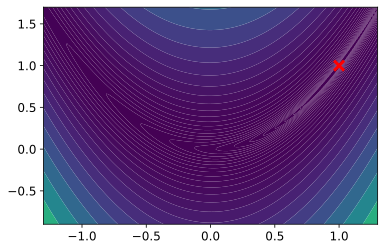

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return (1-x)**2+100*(y-x**2)**2
    
X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250))
Z = f(X,Y)
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

In [ ]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2
    

In [ ]:
import optuna 

study = optuna.create_study()
study.optimize(objective, n_trials = 1000)

In [ ]:
study.best_params

{'x': 0.989509527804537, 'y': 0.979727975781261}

In [ ]:
def hp_space(trial):
  return {'num_train_epochs' : trial.suggest_int('num_train_epcohs', 5, 10),
          'alpha' : trial.suggest_float('alpha', 0, 1),
          'temperature' : trial.suggest_int('temperature', 2, 10)
          }

In [ ]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials = 1, direction='maximize', hp_space = hp_space
)

[I 2023-02-09 14:57:59,501] A new study created in memory with name: no-name-0405227d-b90d-4da4-a2cb-47de1e8a4819
Trial: {'num_train_epcohs': 8, 'alpha': 0.47801543198939267, 'temperature': 2}
loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification f

{'eval_loss': 0.4132431447505951, 'eval_accuracy': 0.6632258064516129, 'eval_runtime': 5.349, 'eval_samples_per_second': 579.543, 'eval_steps_per_second': 12.152, 'epoch': 1.0}


Saving model checkpoint to distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-500
Configuration saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/config.json


{'loss': 0.6436, 'learning_rate': 1.606918238993711e-05, 'epoch': 1.57}


Model weights saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/tokenizer_config.json
Special tokens file saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distillbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distillbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


{'eval_loss': 0.14825232326984406, 'eval_accuracy': 0.844516129032258, 'eval_runtime': 5.7426, 'eval_samples_per_second': 539.826, 'eval_steps_per_second': 11.319, 'epoch': 2.0}


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


{'eval_loss': 0.07644185423851013, 'eval_accuracy': 0.8951612903225806, 'eval_runtime': 5.4169, 'eval_samples_per_second': 572.288, 'eval_steps_per_second': 12.0, 'epoch': 3.0}


Saving model checkpoint to distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-1000
Configuration saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-1000/config.json


{'loss': 0.1694, 'learning_rate': 1.2138364779874214e-05, 'epoch': 3.14}


Model weights saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-1000/tokenizer_config.json
Special tokens file saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-1000/special_tokens_map.json
tokenizer config file saved in distillbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distillbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


{'eval_loss': 0.054401226341724396, 'eval_accuracy': 0.9148387096774193, 'eval_runtime': 5.4443, 'eval_samples_per_second': 569.398, 'eval_steps_per_second': 11.939, 'epoch': 4.0}


Saving model checkpoint to distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-1500
Configuration saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-1500/config.json


{'loss': 0.0857, 'learning_rate': 8.207547169811321e-06, 'epoch': 4.72}


Model weights saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-1500/tokenizer_config.json
Special tokens file saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-1500/special_tokens_map.json
tokenizer config file saved in distillbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distillbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


{'eval_loss': 0.045486047863960266, 'eval_accuracy': 0.9203225806451613, 'eval_runtime': 5.6031, 'eval_samples_per_second': 553.268, 'eval_steps_per_second': 11.601, 'epoch': 5.0}


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


{'eval_loss': 0.04086782783269882, 'eval_accuracy': 0.9245161290322581, 'eval_runtime': 5.3632, 'eval_samples_per_second': 578.011, 'eval_steps_per_second': 12.12, 'epoch': 6.0}


Saving model checkpoint to distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-2000
Configuration saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-2000/config.json


{'loss': 0.0654, 'learning_rate': 4.276729559748428e-06, 'epoch': 6.29}


Model weights saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-2000/tokenizer_config.json
Special tokens file saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-2000/special_tokens_map.json
tokenizer config file saved in distillbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distillbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


{'eval_loss': 0.03852170333266258, 'eval_accuracy': 0.925483870967742, 'eval_runtime': 5.4702, 'eval_samples_per_second': 566.702, 'eval_steps_per_second': 11.882, 'epoch': 7.0}


Saving model checkpoint to distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-2500
Configuration saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-2500/config.json


{'loss': 0.0581, 'learning_rate': 3.459119496855346e-07, 'epoch': 7.86}


Model weights saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-2500/pytorch_model.bin
tokenizer config file saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-2500/tokenizer_config.json
Special tokens file saved in distillbert-base-uncased-finetuned-clinc/run-0/checkpoint-2500/special_tokens_map.json
tokenizer config file saved in distillbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distillbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2023-02-09 15:07:51,771] Trial 0 finished with value: 0.9258064516129032 and parameters: {'num_train_epcohs': 8, 'alpha': 0.47801543198939267, 'temperature': 2}. Best is trial 0 with value: 0.9258064516129032.


{'eval_loss': 0.037627674639225006, 'eval_accuracy': 0.9258064516129032, 'eval_runtime': 5.4791, 'eval_samples_per_second': 565.788, 'eval_steps_per_second': 11.863, 'epoch': 8.0}
{'train_runtime': 591.0427, 'train_samples_per_second': 206.415, 'train_steps_per_second': 4.304, 'train_loss': 0.20190508504333737, 'epoch': 8.0}


In [ ]:
for k, v in best_run.hyperparameters.items():
  print(k)

num_train_epcohs
alpha
temperature


In [ ]:
best_run_auto = {}
best_run_auto['BestRun'] = ({'num_train_epochs' : 10, 'alpha': 0.12468168730193585, 'temperature' : 7})

In [ ]:
best_run

{'BestRun': {'num_train_epochs': 10,
  'alpha': 0.12468168730193585,
  'temperature': 7}}

In [ ]:
for k,v in best_run_auto['BestRun'].items():
  print(k)
  print(v)

num_train_epochs
10
alpha
0.12468168730193585
temperature
7


In [ ]:
student_training_args

In [ ]:
print(best_run)

In [ ]:
for k,v in best_run_auto['BestRun'].items():
  setattr(student_training_args, k, v)

In [18]:
distilled_ckpt = 'distillbert-bert-clinc-bert-optuna'
student_training_args.output_dir = distilled_ckpt 

distil_trainer = DistillationTrainer(model_init = student_init,
                                     teacher_model = teacher_model,
                                     args = student_training_args,
                                     train_dataset = clinc_enc['train'],
                                     eval_dataset = clinc_enc['validation'],
                                     compute_metrics = compute_metrics,
                                     tokenizer = student_tokenizer)

distil_trainer.train()

NameError: ignored

In [ ]:
distil_trainer.push_to_hub('Traing Complete')

Saving model checkpoint to distillbert-bert-clinc-bert-optuna
Configuration saved in distillbert-bert-clinc-bert-optuna/config.json
Model weights saved in distillbert-bert-clinc-bert-optuna/pytorch_model.bin
tokenizer config file saved in distillbert-bert-clinc-bert-optuna/tokenizer_config.json
Special tokens file saved in distillbert-bert-clinc-bert-optuna/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 32.0k/256M [00:00<?, ?B/s]

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/adsjklfsd/distillbert-bert-clinc-bert-optuna
   d68e228..65a9b0d  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/adsjklfsd/distillbert-bert-clinc-bert-optuna
   d68e228..65a9b0d  main -> main

To https://huggingface.co/adsjklfsd/distillbert-bert-clinc-bert-optuna
   65a9b0d..e5e37ad  main -> main

   65a9b0d..e5e37ad  main -> main



'https://huggingface.co/adsjklfsd/distillbert-bert-clinc-bert-optuna/commit/65a9b0dbbb54bcde9f17197e02ebf11aca5eb4e3'

In [20]:
from transformers import pipeline
distilled_ckpt = 'adsjklfsd/distillbert-bert-clinc-bert-optuna'
pipe = pipeline('text-classification', model = distilled_ckpt)
optim_type = 'Distillation(optuna)'
pb = PerformanceBenchMark(pipe, clinc['test'], optim_type = optim_type)
perf_metrics = pb.run_benchmark()
perf_metrics.update(pb.run_benchmark())


모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 81.21 +\- 42.66


NameError: ignored

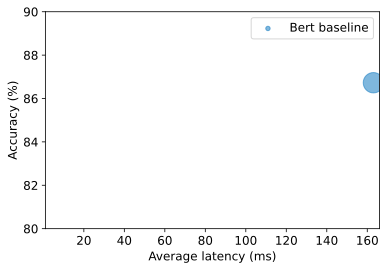

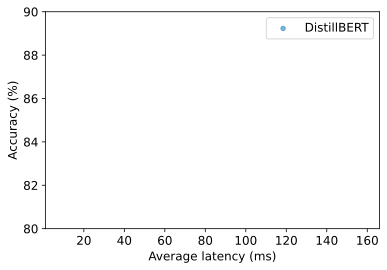

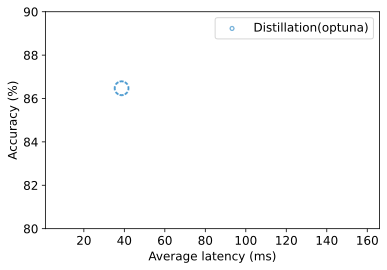

In [ ]:
plot_metrics(perf_metrics, optim_type)

#양자화

In [27]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict() 
weights = state_dict['distilbert.transformer.layer.0.attention.out_lin.weight']
weights

tensor([[-0.0273, -0.0401,  0.0020,  ..., -0.0320, -0.0203,  0.0431],
        [ 0.0457,  0.0131,  0.0080,  ..., -0.0214,  0.0371,  0.0034],
        [-0.0466, -0.0306,  0.0272,  ...,  0.0033,  0.0292, -0.0169],
        ...,
        [ 0.0286,  0.0015,  0.0652,  ...,  0.0006,  0.0332, -0.0024],
        [-0.0001, -0.0130, -0.0664,  ...,  0.0617, -0.0396, -0.0699],
        [-0.0676, -0.0053, -0.0520,  ...,  0.0419,  0.0120, -0.0090]])

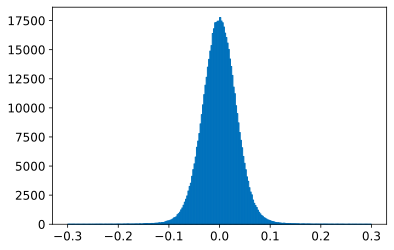

In [29]:
plt.hist(weights.flatten().numpy(), bins=250, range = (-0.3, 0.3), edgecolor = 'C0')
plt.show()

In [34]:
# 대부분 [-0.1, 0.1] 사이의 분포
# 이 텐서를 부호가 있는 8비트 정수로 압축한다고 해보자.
# 이 경우 [Qmax, Qmin] = [-128, 127]
# 원점은 FP32의 원점과 일치하고 스케일링 인자는 이전 공식으로 계산
# f = fmax - fmin / qmax - qmin
zero_point = 0 
scale = (weights.max() - weights.min()) / (127 - (-128))

print((weights / scale + zero_point).clamp(-128, 127).round().char()) #char = int8
 

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   2,   2,  ...,  -4,   7,   1],
        [ -9,  -6,   5,  ...,   1,   6,  -3],
        ...,
        [  5,   0,  12,  ...,   0,   6,   0],
        [  0,  -2, -13,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)


In [37]:
# 토치에선 quantizer_per_tensor로 변환할 수 있다.

from torch import quantize_per_tensor 

dtype = torch.qint8 
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype) 
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   2,   2,  ...,  -4,   7,   1],
        [ -9,  -6,   5,  ...,   1,   6,  -3],
        ...,
        [  5,   0,  12,  ...,   0,   6,   0],
        [  0,  -2, -13,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

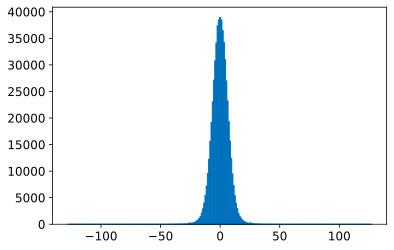

In [41]:
plt.hist(quantized_weights.int_repr().flatten().numpy(), bins=250, range = (-128, 127), edgecolor = 'C0')
plt.show()

In [45]:
%%timeit 
weights @ weights

22.1 ms ± 6.19 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
from torch.nn.quantized import QFunctional 

q_fn = QFunctional() 

In [48]:
%%timeit 

q_fn.mul(quantized_weights, quantized_weights)

312 µs ± 7.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [47]:
import sys 

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

3.999755879241598

In [50]:
from torch.quantization import quantize_dynamic
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_ckpt = 'adsjklfsd/distillbert-bert-clinc-bert-optuna'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) 
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt).to('cpu'))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype = torch.qint8)

In [58]:
pipe = pipeline('text-classification', model = model_quantized,
                tokenizer = tokenizer) 

optim_type = 'Distillation + quantization'
pb = PerformanceBenchMark(pipe, clinc['test'], optim_type = optim_type)
perf_metrics = pb.run_benchmark()
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 132.39
평균 레이턴시 (ms) - 47.82 +\- 11.20
테스트 세트 정확도 - 0.876
모델 크기 (MB) - 132.39
평균 레이턴시 (ms) - 21.27 +\- 4.95
테스트 세트 정확도 - 0.876


KeyError: ignored

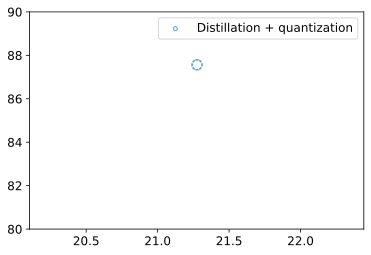

In [66]:
plot_metrics(perf_metrics, optim_type)

# ONNX, ONNX RUNTIME

In [ ]:
import os 
from psutil import cpu_count

os.environ

In [ ]:
cpu_count()

In [71]:
os.environ['OMP_NUM_THREADS'] = f'{cpu_count()}'
os.environ['OMP_WAIT_POLICY'] = 'ACTIVE'

In [72]:
os.environ['OMP_NUM_THREADS']

'2'

In [73]:
# ONNX로 변환하기
from transformers.convert_graph_to_onnx import convert 
model_ckpt = "adsjklfsd/distillbert-bert-clinc-bert-optuna"
onnx_model_path = Path('onnx/model.onnx')
convert(framework = 'pt', model = model_ckpt, tokenizer = tokenizer,
        output = onnx_model_path, opset=12, pipeline_name = 'text-classification')

/usr/local/lib/python3.8/dist-packages/transformers/convert_graph_to_onnx.py:380: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(


ONNX opset version set to: 12
Loading pipeline (model: adsjklfsd/distillbert-bert-clinc-bert-optuna, tokenizer: DistilBertTokenizerFast(name_or_path='adsjklfsd/distillbert-bert-clinc-bert-optuna', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}))
Creating folder onnx
Using framework PyTorch: 1.13.1+cu116
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


/usr/local/lib/python3.8/dist-packages/transformers/models/distilbert/modeling_distilbert.py:218: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


In [76]:
# 모델을 저장했으므로, 모델에 입력을 전달하기 위한 InferenceSession을 만들어보자.

from onnxruntime import (GraphOptimizationLevel, InferenceSession,SessionOptions)

def create_model_for_provider(model_path, provider = 'CPUExecutionProvider'):
  options = SessionOptions() 
  options.intra_op_num_threads = 1 
  options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL 
  session = InferenceSession(str(model_path), options, providers = [provider]) 
  session.disable_fallback()
  return session 

onnx_model = create_model_for_provider(onnx_model_path)

In [82]:
inputs = clinc_enc['test'][:1]
del inputs['labels']
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx

array([[-1.4058769 , -1.999365  , -1.4186726 , -1.1935791 , -1.997211  ,
        -0.9840398 , -2.0962663 , -0.62386185, -0.5641223 , -2.889511  ,
        -1.0821797 ,  0.23975451, -3.567853  , -0.41211355, -1.7611088 ,
        -1.6600614 , -2.9991517 , -1.5412035 , -1.9129833 , -2.853946  ,
        -0.5623196 , -0.5000465 , -1.2447957 , -1.2153623 , -2.4549677 ,
        -2.2622454 , -2.3949156 , -1.8453684 , -0.29267868,  2.801347  ,
        -1.3790672 , -1.4282529 , -1.0076089 , -0.00671172, -1.8158332 ,
        -2.8289475 , -0.43891793, -1.3725022 , -0.3460206 , -1.5923059 ,
        -0.96042436, -0.84389347,  0.01595496, -2.4059644 , -1.5761544 ,
        -1.9253576 , -2.0354629 , -1.2227917 , -1.3044248 , -2.8590918 ,
        -0.8587483 , -1.0657479 , -1.6981595 , -2.0170898 , -2.3384385 ,
        -1.3270636 , -1.1963404 , -0.72642076, -1.4765148 , -1.8933885 ,
        -0.7739188 ,  5.7108593 , -0.09126577, -0.57624865, -2.1330597 ,
        -2.0256891 , -1.5352445 , -1.2102852 , -1.6

In [83]:
np.argmax(logits_onnx)

61

In [84]:
clinc_enc['test'][0]['labels']

61

In [87]:
from scipy.special import softmax 

class OnnxPipeline:
  def __init__(self, model, tokenizer):
    self.model = model
    self.tokenizer = tokenizer 

  def __call__(self, query):
    model_inputs = self.tokenizer(query, return_tensors = 'pt')
    inputs_onnx = {k:v.cpu().detach().numpy() for k,v in model_inputs.items()}
    logits = self.model.run(None, inputs_onnx)[0][0, :] 
    probs = softmax(logits)
    pred_idx = np.argmax(probs).item() 
    return [{'label' : intents.int2str(pred_idx), 'score': probs[pred_idx]}]

In [88]:
pipe = OnnxPipeline(onnx_model, tokenizer)

query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in 
Paris and I need a 15 passenger van"""


pipe(query)

[{'label': 'car_rental', 'score': 0.75793886}]

In [91]:
class OnnxPerformanceBenchmark(PerformanceBenchMark):
  def __init__(self, *args, model_path, **kwargs):
    super().__init__(*args, **kwargs)
    self.model_path = model_path

  def compute_size(self):
    size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
    print(f'모델크기 (MB) - {size_mb:.2f}')
    return {'size_mb': size_mb}

In [109]:
optim_type = 'distillation + ORT'
pb = OnnxPerformanceBenchmark(pipe, clinc['test'], optim_type, model_path = 'onnx/model.onnx')
perf_metrics.update(pb.run_benchmark())

모델크기 (MB) - 255.98
평균 레이턴시 (ms) - 13.07 +\- 2.64
테스트 세트 정확도 - 0.878


In [110]:
perf_metrics

{'Distillation + quantization': {'size_mb': 255.97947025299072,
  'time_avg_ms': 60.81434435003757,
  'time_std_ms': 17.94904580143733,
  'accuracy': 0.8647272727272727},
 'distillation + ORT': {'size_mb': 255.97947025299072,
  'time_avg_ms': 13.066621770003621,
  'time_std_ms': 2.6370526164842274,
  'accuracy': 0.8778181818181818}}

KeyError: ignored

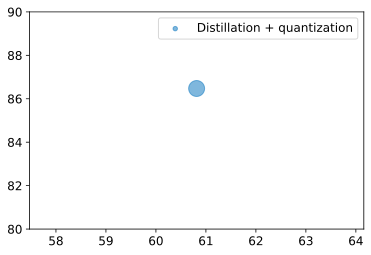

In [101]:
plot_metrics(perf_metrics, optim_type)

# ONNX 양자화


In [97]:
from onnxruntime.quantization import quantize_dynamic, QuantType 

model_input = 'onnx/model.onnx'
model_output = 'onnx/model.quant.onnx'
quantize_dynamic(model_input, model_output, weight_type = QuantType.QInt8)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

In [111]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = 'disstillation + ORT + Quantized'
pb = OnnxPerformanceBenchmark(pipe, clinc['test'], optim_type, model_path = model_output)
perf_metrics.update(pb.run_benchmark())

모델크기 (MB) - 64.33
평균 레이턴시 (ms) - 25.74 +\- 24.96
테스트 세트 정확도 - 0.878


In [112]:
perf_metrics

{'Distillation + quantization': {'size_mb': 255.97947025299072,
  'time_avg_ms': 60.81434435003757,
  'time_std_ms': 17.94904580143733,
  'accuracy': 0.8647272727272727},
 'distillation + ORT': {'size_mb': 255.97947025299072,
  'time_avg_ms': 13.066621770003621,
  'time_std_ms': 2.6370526164842274,
  'accuracy': 0.8778181818181818},
 'disstillation + ORT + Quantized': {'size_mb': 64.32706260681152,
  'time_avg_ms': 25.740437209924494,
  'time_std_ms': 24.958268077769752,
  'accuracy': 0.8778181818181818}}

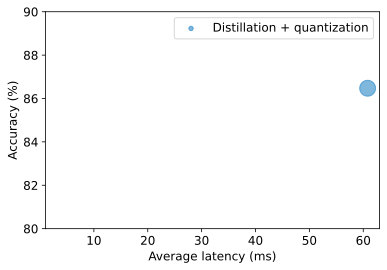

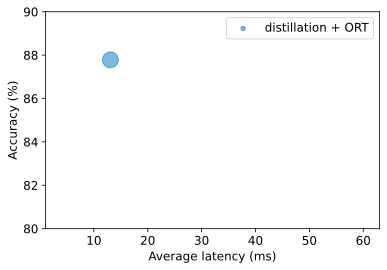

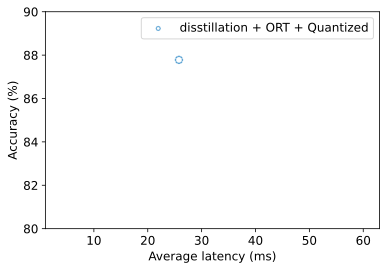

In [113]:
plot_metrics(perf_metrics, optim_type)